In [94]:
from enum import Enum

import pandas as pd
import numpy as np

import os
import cv2
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

from PIL import Image

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torch.utils.data.dataloader import DataLoader

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [96]:
from azure.storage.blob import BlobServiceClient

In [97]:
# Setting up the data from the bucket

connection_string = os.getenv('AZURE_CONNECTION_STRING')
container_train_name = "epitech-zoidberg-dataset-train"
container_val_name = "epitech-zoidberg-dataset-validation"
container_test_name = "epitech-zoidberg-dataset-test"


blob_service_client = BlobServiceClient.from_connection_string(connection_string)

In [98]:
class EOutput(Enum):
  NEGATIVE = 0
  BACTERIA = 1
  VIRUS = 2

class EDataset(Enum):
  TRAIN = 0
  VALIDATION = 1
  TEST = 2

In [99]:
train_tfms = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomRotation([-10, 10]),
    tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    tt.ToTensor(),
    tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

valid_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_tfms = tt.ToTensor()

In [100]:
image_size = 75
batch_size = 300
input_layer = image_size*image_size

In [103]:
# Download images from Azure Storage Account

def load_blob_from_container(container_name, dataset_type):
    images = []
    labels = []

    container_client = blob_service_client.get_container_client(container_name)
    blobs = container_client.list_blobs()

    for blob in blobs:

        blob_client = blob_service_client.get_blob_client(container_name, blob.name)
        stream = blob_client.download_blob().readall()

        nparr = np.frombuffer(stream, np.uint8)

        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if img is None: continue

        img = cv2.resize(img, (image_size, image_size))

        if dataset_type == EDataset.TRAIN:
            images.append(
                train_tfms(Image.fromarray(img))
            )
        elif dataset_type == EDataset.VALIDATION:
            images.append(
                valid_tfms(Image.fromarray(img))
            )
        else :
            images.append(
                test_tfms(Image.fromarray(img))
            )

        if "bacteria" in blob.name:
            labels.append(EOutput.BACTERIA.value)
            continue

        if "virus" in blob.name:
            labels.append(EOutput.VIRUS.value)
            continue

        labels.append(EOutput.NEGATIVE.value)

    return list(zip(images, labels))

In [104]:
train_ds = load_blob_from_container(container_name=container_train_name, dataset_type=EDataset.TRAIN)
val_ds = load_blob_from_container(container_name=container_val_name, dataset_type=EDataset.VALIDATION)
test_ds = load_blob_from_container(container_name=container_test_name, dataset_type=EDataset.TEST)

In [11]:
fold_ds = train_ds + val_ds

In [105]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")
print(f"Test dataset size: {len(fold_ds)}")

Train dataset size: 4684
Validation dataset size: 586
Test dataset size: 585
Test dataset size: 5270


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


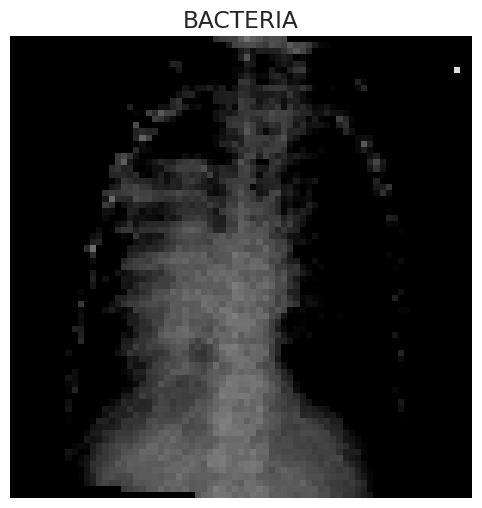

In [108]:
image, label = train_ds[np.random.randint(0, len(train_ds))]

plt.imshow(image.permute(1, 2, 0))
plt.title(EOutput(label).name)
plt.axis('off')
plt.show()

In [109]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [110]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        _, preds = torch.max(out, dim=1)
        probs = F.softmax(out, dim=1)
        return {'val_loss': loss.detach(), 'val_acc': acc, 'preds': preds, 'labels': labels, 'probs': probs}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        batch_preds = [x['preds'] for x in outputs]
        batch_probs = [x['probs'] for x in outputs]
        batch_labels = [x['labels'] for x in outputs]

        preds = torch.cat(batch_preds)
        labels = torch.cat(batch_labels)
        probs = torch.cat(batch_probs)

        f1 = f1_score(labels.cpu(), preds.cpu(), average='macro')
        roc_auc = roc_auc_score(labels.cpu().numpy(), probs.cpu().numpy(), multi_class='ovo')

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'f1': f1, 'roc_auc': roc_auc}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, f1_score:{:.4f}, roc_auc_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['f1'], result['roc_auc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [111]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
  ]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv = nn.Sequential(
      conv_block(channels, channels),
      conv_block(channels, channels)
    )

  def forward(self, x):
    return self.conv(x) + x

class ResNet(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv = nn.Sequential(
        conv_block(in_channels, 64),
        conv_block(64, 128, pool=True),
        conv_block(128, 128, pool=True),
        ResidualBlock(128),

        conv_block(128, 256),
        ResidualBlock(256),
        conv_block(256, 512),
        ResidualBlock(512),
        conv_block(512, 256),
        ResidualBlock(256),
        conv_block(256, 128),
        ResidualBlock(128),

        conv_block(128, 256, pool=True),
        conv_block(256, 512, pool=True),
        ResidualBlock(512),

        nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    )

  def forward(self, xb):
    return self.conv(xb)

In [112]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lr'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

def cross_validation(epochs, max_lr, model, fold_ds, k_folds=5, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

  kfold = KFold(n_splits=k_folds, shuffle=True)
  
  history = []

  for fold, (train_ids, val_ids) in enumerate(kfold.split(fold_ds)):
    print(f'====== FOLD {fold} ======')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    test_dl = DataLoader(fold_ds, batch_size,sampler=test_subsampler , num_workers=2, pin_memory=True)
    fold_dl = DataLoader(fold_ds, batch_size, sampler=train_subsampler, num_workers=2, pin_memory=True)
    
    test_dl = DeviceDataLoader(test_dl, device)
    fold_dl = DeviceDataLoader(fold_dl, device)
    
    learning_rate = max_lr / ((fold * 10) + 1)
    history += fit(epochs, learning_rate, model, fold_dl, test_dl, weight_decay, grad_clip, opt_func)
     
  return history
  

In [113]:
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [120]:
model = to_device(ResNet(3, 3), device)
history = [evaluate(model, test_dl)]
history[0]["train_loss"] = 0

In [121]:
%%time
history += cross_validation(
    k_folds=5,
    epochs=5,
    max_lr=1e-3,
    model=model,
    fold_ds=fold_ds,
    weight_decay=2e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

====== FOLD 0 ======


Epoch [0], train_loss: 0.8766, val_loss: 1.7040, val_acc: 0.4761, f1_score:0.2157, roc_auc_score: 0.4433
Epoch [1], train_loss: 0.7014, val_loss: 3.3094, val_acc: 0.2602, f1_score:0.1898, roc_auc_score: 0.4020
Epoch [2], train_loss: 0.6457, val_loss: 3.4225, val_acc: 0.4868, f1_score:0.2552, roc_auc_score: 0.7335
Epoch [3], train_loss: 0.5545, val_loss: 0.6282, val_acc: 0.7415, f1_score:0.7199, roc_auc_score: 0.8776
Epoch [4], train_loss: 0.5052, val_loss: 0.5213, val_acc: 0.7831, f1_score:0.7702, roc_auc_score: 0.9058
====== FOLD 1 ======
Epoch [0], train_loss: 0.4985, val_loss: 0.5253, val_acc: 0.7756, f1_score:0.7398, roc_auc_score: 0.9134
Epoch [1], train_loss: 0.4910, val_loss: 0.5007, val_acc: 0.7899, f1_score:0.7717, roc_auc_score: 0.9150
Epoch [2], train_loss: 0.4995, val_loss: 0.4704, val_acc: 0.7957, f1_score:0.7821, roc_auc_score: 0.9205
Epoch [3], train_loss: 0.4799, val_loss: 0.4935, val_acc: 0.7924, f1_score:0.7774, roc_auc_score: 0.9178
Epoch [4], train_loss: 0.4442, val

In [122]:
def plot_acc_f1_roc(history):
    val_acc = [x['val_acc'] for x in history]
    val_f1 = [x['f1'] for x in history]
    val_roc = [x['roc_auc'] for x in history]
    plt.plot(val_acc, '-bx')
    plt.plot(val_f1, '-rx')
    plt.plot(val_roc, '-gx')
    plt.xlabel('epoch')
    plt.ylabel('metrics')
    plt.legend(['Accuracy', 'F1 Score', 'ROC AUC'])
    plt.title('Metrics vs. No. of epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

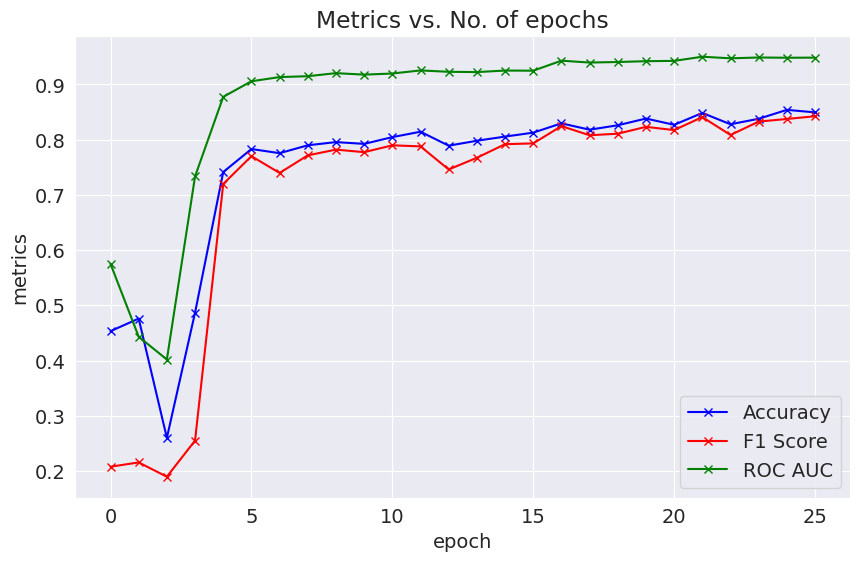

In [123]:
plot_acc_f1_roc(history)

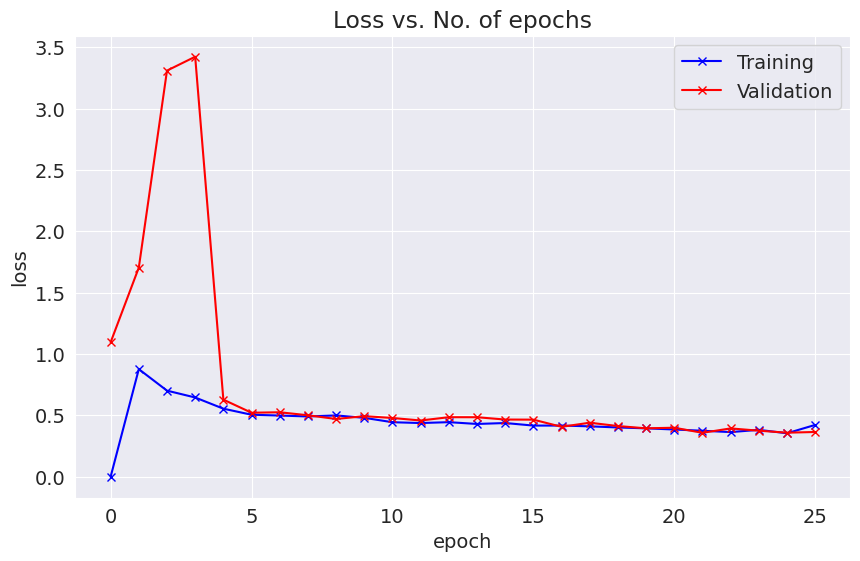

In [124]:
plot_losses(history)

Label: VIRUS, prediction: VIRUS


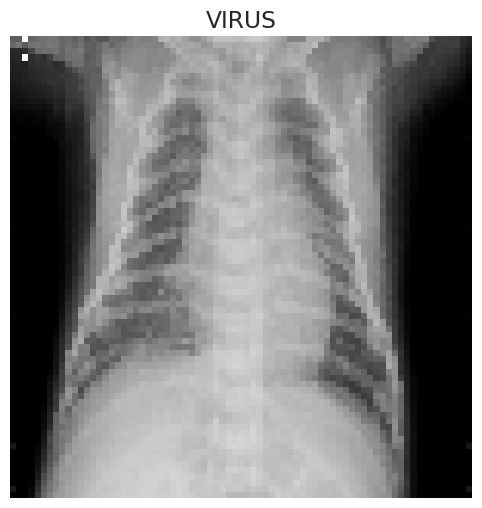

In [73]:
image, label = test_ds[np.random.randint(0, len(test_ds))]

plt.imshow(image.permute(1, 2, 0))
plt.title(EOutput(label).name)

pred = model(to_device(image.unsqueeze(0), device))

print(f"Label: {EOutput(label).name}, prediction: {EOutput(torch.max(pred, dim=1)[1].item()).name}")

plt.axis('off')

plt.show()

In [125]:
result = evaluate(model, test_dl)
print(result)


{'val_loss': 0.5028197169303894, 'val_acc': 0.8210526704788208, 'f1': 0.8064765007124457, 'roc_auc': 0.9259134049976203}


In [126]:
file_meta_data = [("val_loss", "val_acc", "train_loss", "f1", "roc_auc")]
file_data_csv = [(i["val_loss"], i["val_acc"], i["train_loss"], i["f1"], i["roc_auc"]) for i in history]

full_file = file_meta_data + file_data_csv

In [127]:
path = os.path.join(os.getcwd(), "model_result.csv")
print(path)
with open(path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(full_file)

/home/dany_leguy/models/model4/model_result.csv


In [128]:
model_file_name = "model.pth"
model_path = os.path.join(os.getcwd(), model_file_name)

In [129]:
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path))

In [74]:
# Checks if you have the permissions to write in this folder.
try:
    with open(os.path.join(os.getcwd(), 'temp.txt'), 'w') as f:
        pass
    print("Write permissions check passed.")
except:
    print("Write permissions check failed.")

Write permissions check passed.
